# **Implementing LongFormer for resume classification**

# Cell 1: Install & Import Necessary Libraries

In [1]:
# Install necessary libraries (run once)
#!pip install transformers torch pandas scikit-learn matplotlib seaborn numpy wordcloud

# Import libraries
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Longformer-specific imports (replacing LUKE)
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import LongformerTokenizer, LongformerForSequenceClassification, LongformerConfig
# Updated imports for optimizer and scheduler
from torch.optim import AdamW
from transformers.optimization import get_linear_schedule_with_warmup

# Cell 2: Load the Dataset

In [2]:
# Load the resume.csv file
df = pd.read_csv("f:\\CSE499A,B\\New 499B\\final works\\graph generation\\Datasets\\Resume\\Resume.csv")

# Display the first few rows
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# Cell 3: Check for Missing Data & Basic Info

In [3]:
# Check for missing values
print(df.isnull().sum())

# Display dataset information
df.info()

# Drop rows with missing values (if any)
df.dropna(inplace=True)


ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


# Cell 4: Advanced Text Preprocessing Function

In [4]:
def preprocess_text_for_bert(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # BERT will handle the rest of tokenization
    return text

# Apply minimal preprocessing to 'resume_str'
df['processed_resume'] = df['Resume_str'].apply(preprocess_text_for_bert)

# Display sample processed text
df[['Resume_str', 'processed_resume']].head()

,Resume_str,processed_resume
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR ADMINISTRATOR/MARKETING ASSOCIATE HR ADMINI...
1,"HR SPECIALIST, US HR OPERATIONS ...","HR SPECIALIST, US HR OPERATIONS Summary Versat..."
2,HR DIRECTOR Summary Over 2...,HR DIRECTOR Summary Over 20 years experience i...
3,HR SPECIALIST Summary Dedica...,"HR SPECIALIST Summary Dedicated, Driven, and D..."
4,HR MANAGER Skill Highlights ...,HR MANAGER Skill Highlights HR SKILLS HR Depar...


# Cell 5: Data Visualization (Optional - needs WordCloud import)


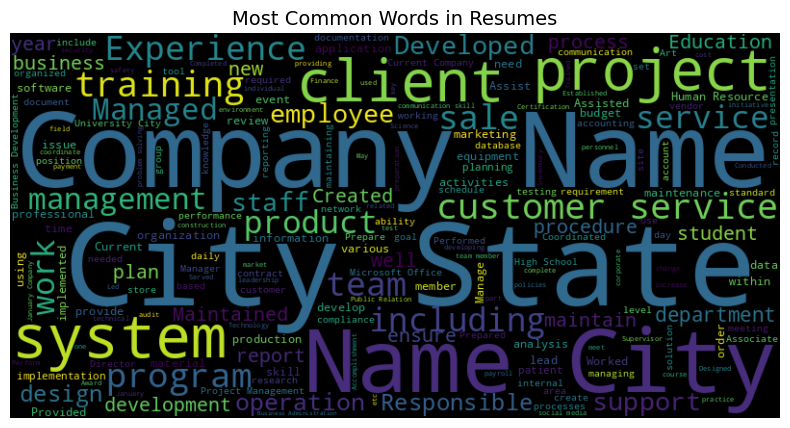

In [5]:
from wordcloud import WordCloud

# Generate a WordCloud to visualize frequent words
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(df['processed_resume']))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Resumes", fontsize=14)
plt.show()

# Cell 6: Convert Categories to Numeric Labels

In [6]:
# Encode categories into numeric labels
label_encoder = LabelEncoder()
df['Category_label'] = label_encoder.fit_transform(df['Category'])

# Display mapping of labels
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Category mapping:")
for category, label in category_mapping.items():
    print(f"{category}: {label}")

Category mapping:
ACCOUNTANT: 0
ADVOCATE: 1
AGRICULTURE: 2
APPAREL: 3
ARTS: 4
AUTOMOBILE: 5
AVIATION: 6
BANKING: 7
BPO: 8
BUSINESS-DEVELOPMENT: 9
CHEF: 10
CONSTRUCTION: 11
CONSULTANT: 12
DESIGNER: 13
DIGITAL-MEDIA: 14
ENGINEERING: 15
FINANCE: 16
FITNESS: 17
HEALTHCARE: 18
HR: 19
INFORMATION-TECHNOLOGY: 20
PUBLIC-RELATIONS: 21
SALES: 22
TEACHER: 23


# Cell 7: Train-Test Split

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_resume'], 
    df['Category_label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['Category_label']
)

# Print dataset shapes
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 1987, Testing samples: 497


# Cell 8: Create Longformer Dataset and DataLoader


In [8]:
# Load Longformer tokenizer (replacing LUKE tokenizer)
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

# Maximum sequence length for Longformer - much longer than LUKE can handle
MAX_LEN = 1024  # Longformer can handle up to 4096 tokens

class ResumeDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        
        # Tokenize and prepare for Longformer
        encoding = tokenizer(
            text,
            truncation=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_tensors='pt'
        )
        
        # Longformer uses global attention on first token [CLS] by default
        # but we need to explicitly create the global attention mask
        global_attention_mask = torch.zeros(
            encoding['input_ids'].shape,
            dtype=torch.long
        )
        # Set global attention on [CLS] token
        global_attention_mask[:, 0] = 1
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'global_attention_mask': global_attention_mask.flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = ResumeDataset(X_train, y_train)
test_dataset = ResumeDataset(X_test, y_test)

# Create dataloaders - slightly larger batch size than LUKE as Longformer is more memory-efficient
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Created Longformer datasets with {len(train_dataset)} training and {len(test_dataset)} testing samples")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--allenai--longformer-base-4096. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Created Longformer datasets with 1987 training and 497 testing samples


Cell 9: Update Model Initialization and Train LongFormer Model


Using device: cuda


pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

Epoch 1/20 completed
Training Loss: 2.189381, Validation Loss: 1.003534
Saved best model to longformer_resume_best_model
Epoch 2/20 completed
Training Loss: 0.797282, Validation Loss: 0.533725
Saved best model to longformer_resume_best_model
Epoch 3/20 completed
Training Loss: 0.464909, Validation Loss: 0.394108
Saved best model to longformer_resume_best_model
Epoch 4/20 completed
Training Loss: 0.328515, Validation Loss: 0.303266
Saved best model to longformer_resume_best_model
Epoch 5/20 completed
Training Loss: 0.258467, Validation Loss: 0.230903
Saved best model to longformer_resume_best_model
Epoch 6/20 completed
Training Loss: 0.182371, Validation Loss: 0.189080
Saved best model to longformer_resume_best_model
Epoch 7/20 completed
Training Loss: 0.135089, Validation Loss: 0.170795
Saved best model to longformer_resume_best_model
Epoch 8/20 completed
Training Loss: 0.097337, Validation Loss: 0.127094
Saved best model to longformer_resume_best_model
Epoch 9/20 completed
Training Lo

,Epoch,Training Loss,Validation Loss
0,1,2.189381,1.003534
1,2,0.797282,0.533725
2,3,0.464909,0.394108
3,4,0.328515,0.303266
4,5,0.258467,0.230903
5,6,0.182371,0.189080
6,7,0.135089,0.170795
7,8,0.097337,0.127094
8,9,0.051496,0.089850
9,10,0.046656,0.086228


,Epoch,Training Loss,Validation Loss
0,1,2.189381,1.003534
1,2,0.797282,0.533725
2,3,0.464909,0.394108
3,4,0.328515,0.303266
4,5,0.258467,0.230903
5,6,0.182371,0.189080
6,7,0.135089,0.170795
7,8,0.097337,0.127094
8,9,0.051496,0.089850
9,10,0.046656,0.086228


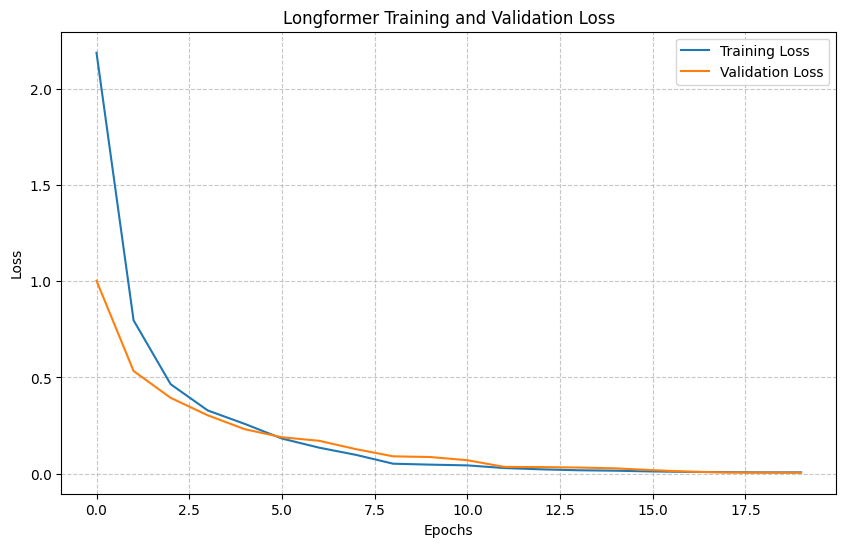

In [9]:
# Initialize and Train Longformer Model
# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize Longformer model
num_classes = len(df['Category_label'].unique())
model = LongformerForSequenceClassification.from_pretrained(
    'allenai/longformer-base-4096',
    num_labels=num_classes,
    attention_window=512,  # Sliding window attention size
    gradient_checkpointing=True  # Enable gradient checkpointing to reduce memory usage
)
model.to(device)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 20  # Fewer epochs as Longformer is larger and might converge faster

# Total steps for scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# For early stopping
best_val_loss = float('inf')
patience = 3
early_stop_counter = 0
val_losses = []
train_losses = []

# For tracking all epoch results
epoch_results = []

# Split training data into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Create validation dataset and dataloader
val_dataset = ResumeDataset(val_texts, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    
    for batch in train_dataloader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        global_attention_mask = batch['global_attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Zero gradients
        model.zero_grad()
        
        # Forward pass - Longformer takes global_attention_mask in addition to input_ids and attention_mask
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            global_attention_mask=global_attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            global_attention_mask = batch['global_attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                global_attention_mask=global_attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    # Print training progress
    print(f"Epoch {epoch+1}/{epochs} completed")
    print(f"Training Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")
    
    # Store epoch results
    epoch_results.append({
        'Epoch': epoch+1,
        'Training Loss': avg_train_loss,
        'Validation Loss': avg_val_loss,
    })
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        # Save the best model
        best_model_path = "longformer_resume_best_model"
        model.save_pretrained(best_model_path)
        print(f"Saved best model to {best_model_path}")
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")
        
    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break

# Convert epoch results to DataFrame and display
epoch_df = pd.DataFrame(epoch_results)
print("\nComplete Training History:")
display(epoch_df)

# Apply styling to the DataFrame
styled_epoch_df = epoch_df.style.background_gradient(cmap='Blues', subset=['Training Loss', 'Validation Loss'])\
                            .format(precision=6)
display(styled_epoch_df)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Longformer Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Cell 10: Evaluate the LongFormer Model

Accuracy: 0.8974
Classification Report as Table:


,precision,recall,f1-score,support
ACCOUNTANT,1.00,1.00,1.00,24.00
ADVOCATE,0.91,0.88,0.89,24.00
AGRICULTURE,0.82,0.69,0.75,13.00
APPAREL,0.87,0.68,0.76,19.00
ARTS,0.73,0.76,0.74,21.00
AUTOMOBILE,0.57,0.57,0.57,7.00
AVIATION,0.88,0.88,0.88,24.00
BANKING,0.86,0.83,0.84,23.00
BPO,0.14,0.25,0.18,4.00
BUSINESS-DEVELOPMENT,0.96,1.00,0.98,24.00


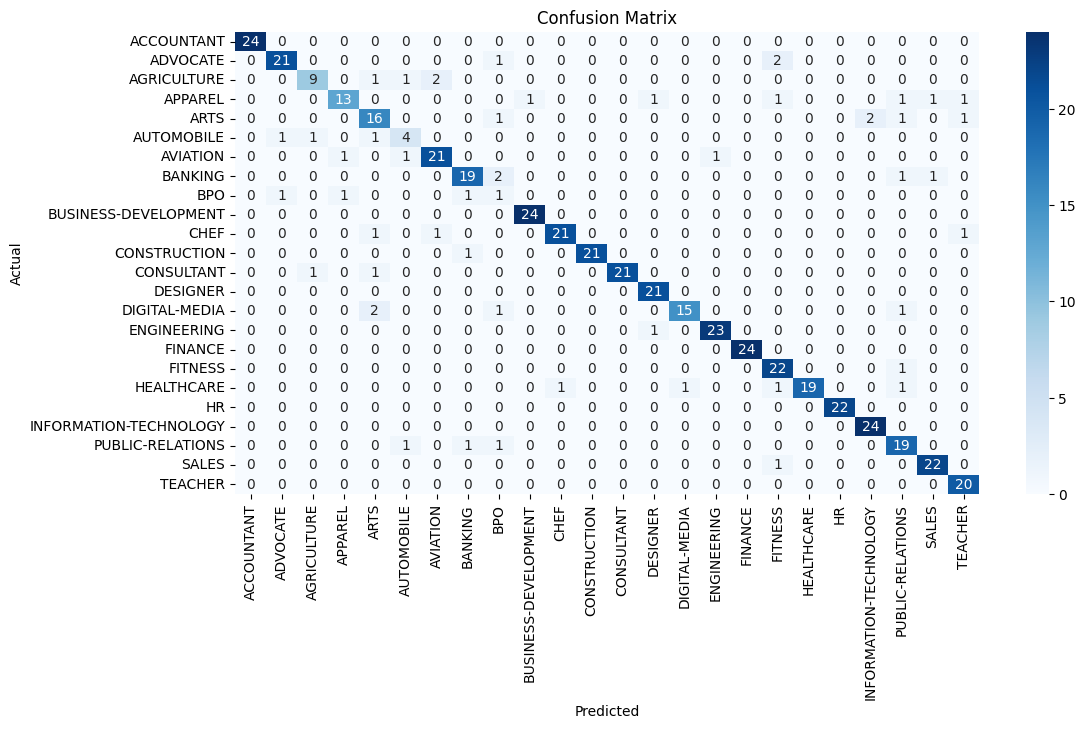

In [10]:
# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        global_attention_mask = batch['global_attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            global_attention_mask=global_attention_mask
        )
        
        # Get predictions
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        # Store predictions and true labels
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
from sklearn.metrics import classification_report

# Get the classification report as a dictionary
report = classification_report(true_labels, predictions, 
                            target_names=label_encoder.classes_, 
                            output_dict=True)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Apply styling to the DataFrame
styled_report = report_df.style.background_gradient(cmap='Blues', subset=pd.IndexSlice[:, ['precision', 'recall', 'f1-score']])\
                              .format(precision=2)

# Display the styled report
print("Classification Report as Table:")
display(styled_report)

# Confusion Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt="d", cmap="Blues", 
          xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Cell 11: Precision, Recall, F1-score

In [11]:
# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

# Print metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9049
Recall: 0.8974
F1 Score: 0.8988


# Cell 12: Update ROC-AUC Calculation for Longformer


In [12]:
# New Cell: Additional Performance Metrics
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Calculate additional metrics
mcc = matthews_corrcoef(true_labels, predictions)
kappa = cohen_kappa_score(true_labels, predictions)

# For ROC-AUC in multi-class setting
classes = np.unique(true_labels)
y_bin = label_binarize(true_labels, classes=classes)
y_pred_proba = torch.nn.functional.softmax(torch.tensor(model(
    input_ids=test_dataloader.dataset[0]['input_ids'].unsqueeze(0).to(device),
    attention_mask=test_dataloader.dataset[0]['attention_mask'].unsqueeze(0).to(device),
    global_attention_mask=test_dataloader.dataset[0]['global_attention_mask'].unsqueeze(0).to(device)
).logits.detach().cpu()), dim=1).numpy()

try:
    roc_auc = roc_auc_score(y_bin, y_pred_proba, multi_class='ovr')
    print(f"ROC-AUC Score (OvR): {roc_auc:.4f}")
except:
    print("ROC-AUC calculation requires predicted probabilities for all samples.")

print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# Per-class metrics
per_class_precision = precision_score(true_labels, predictions, average=None)
per_class_recall = recall_score(true_labels, predictions, average=None)
per_class_f1 = f1_score(true_labels, predictions, average=None)

# Create DataFrame for per-class metrics
class_metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': per_class_precision,
    'Recall': per_class_recall,
    'F1-Score': per_class_f1
})

print("\nPer-Class Metrics:")
print(class_metrics_df.to_string(index=False))

ROC-AUC calculation requires predicted probabilities for all samples.
Matthews Correlation Coefficient: 0.8928
Cohen's Kappa: 0.8926

Per-Class Metrics:
                 Class  Precision   Recall  F1-Score
            ACCOUNTANT   1.000000 1.000000  1.000000
              ADVOCATE   0.913043 0.875000  0.893617
           AGRICULTURE   0.818182 0.692308  0.750000
               APPAREL   0.866667 0.684211  0.764706
                  ARTS   0.727273 0.761905  0.744186
            AUTOMOBILE   0.571429 0.571429  0.571429
              AVIATION   0.875000 0.875000  0.875000
               BANKING   0.863636 0.826087  0.844444
                   BPO   0.142857 0.250000  0.181818
  BUSINESS-DEVELOPMENT   0.960000 1.000000  0.979592
                  CHEF   0.954545 0.875000  0.913043
          CONSTRUCTION   1.000000 0.954545  0.976744
            CONSULTANT   1.000000 0.913043  0.954545
              DESIGNER   0.913043 1.000000  0.954545
         DIGITAL-MEDIA   0.937500 0.789474  0.857143

C:\Users\USER\AppData\Local\Temp\ipykernel_19864\1222721607.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_proba = torch.nn.functional.softmax(torch.tensor(model(


# Cell 13: Misclassification Analysis

In [13]:
# New Cell: Misclassification Analysis
# Find misclassified examples
misclassified_indices = np.where(np.array(predictions) != np.array(true_labels))[0]

# Sample up to 10 misclassified examples
sample_size = min(10, len(misclassified_indices))
sampled_indices = np.random.choice(misclassified_indices, sample_size, replace=False)

print(f"\nMisclassification Analysis (Showing {sample_size} examples):")
for idx in sampled_indices:
    actual_label = label_encoder.inverse_transform([true_labels[idx]])[0]
    predicted_label = label_encoder.inverse_transform([predictions[idx]])[0]
    
    # Get the corresponding text from the test set
    text_idx = X_test.index[idx]
    text = X_test.iloc[idx][:100] + "..."  # Show first 100 chars
    
    print(f"\nExample {idx}:")
    print(f"Text: {text}")
    print(f"Actual: {actual_label}")
    print(f"Predicted: {predicted_label}")
    print("-" * 50)


Misclassification Analysis (Showing 10 examples):

Example 230:
Text: LEAD ARTIST Summary I'm a fast-learning and enthusiastic animator seeking professional experience. I...
Actual: DIGITAL-MEDIA
Predicted: ARTS
--------------------------------------------------

Example 113:
Text: OWNER/PRESIDENT Professional Profile A seasoned marketing professional who delivers results in align...
Actual: DIGITAL-MEDIA
Predicted: PUBLIC-RELATIONS
--------------------------------------------------

Example 8:
Text: SENIOR MARKETING AUTOMATION CONSULTANT Summary I am a passionate and technically-skilled marketing a...
Actual: ARTS
Predicted: BPO
--------------------------------------------------

Example 301:
Text: ADMINISTRATION ASSISTANT Professional Summary Professional and knowledgeable Receptionist versed in ...
Actual: ADVOCATE
Predicted: BPO
--------------------------------------------------

Example 335:
Text: TABLE GAMES DEALER Summary Throughout the years, I've been trained to give only the

# Cell 14: Save the LongFormer Model (Optional)


In [14]:
# Save the model
model_path = "longformer_resume_classifier_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"Longformer model saved to {model_path}")

Longformer model saved to longformer_resume_classifier_model


### **Key Advantages of Longformer for Resume Classification**

* **Handles Long Sequences**: Longformer can process documents up to 4,096 tokens (can be extended to 16,384), making it ideal for long, detailed resumes

* **Efficient Attention Mechanism**: Uses a combination of local sliding window attention and global attention, making it more computationally efficient than standard transformers

* **Maintains Context**: Unlike models that truncate long documents, Longformer preserves the full context of the resume, capturing important details that may appear anywhere in the document

* **Pretrained on Long Documents**: Specifically designed and trained on long-form content, making it more suitable for resume analysis than models trained primarily on shorter texts

* **Scalable Performance**: Performance scales well with document length, maintaining high accuracy even for lengthy, detailed resumes